In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# choose oparating system

syst_op = 'mac'

if syst_op == 'mac':
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')
elif syst_op == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')

In [2]:
# open the .tif file

with rasterio.open("pre_processing/maps/max_all_storms.tif") as src:
    # Read the entire image
    image_array = src.read()

with rasterio.open("pre_processing/cluster/dem_025_eu.tif") as src:
    # Read the entire image
    dem_array = src.read()

# Read the .tfw file
with open("pre_processing/maps/wind_maps/max_all_storms.tfw") as f:
    tfw_data = [float(line.strip()) for line in f.readlines()]

# Unpack the transformation parameters
pixel_size_x, rotation_y, rotation_x, pixel_size_y, x_origin, y_origin = tfw_data

# remove the first dimension

wind_array = np.squeeze(image_array)

In [3]:
# Define the dimensions of your wind speed array
rows, cols = wind_array.shape

# Generate the latitude and longitude arrays
latitudes = y_origin + np.arange(rows) * pixel_size_y
longitudes = x_origin + np.arange(cols) * pixel_size_x

# Create mesh grids for latitude and longitude
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')

In [4]:
# Flatten grids and wind_speed array
lat_flat = lat_grid.flatten()
lon_flat = lon_grid.flatten()
wind_flat = wind_array.flatten()

dem_flat = dem_array.flatten()

# Combine into a single array
result = np.column_stack((lat_flat, lon_flat, wind_flat, dem_flat))
df = pd.DataFrame(result, columns=['Latitude', 'Longitude', 'Wind Speed','DEM'])

# save the dataframe as a .csv file
#df.to_csv('pre_processing/cluster/max_all_storms.csv', index=False)

# Show first few rows
print(df.head())

   Latitude  Longitude  Wind Speed  DEM
0      71.0     -12.00         NaN  0.0
1      71.0     -11.75         NaN  0.0
2      71.0     -11.50         NaN  0.0
3      71.0     -11.25         NaN  0.0
4      71.0     -11.00         NaN  0.0


In [5]:
# now create clusters using the k-means algorithm

data = wind_flat.reshape(-1, 1)
data = data[~np.isnan(data)]#data[data < 1e7]
data = data.reshape(-1, 1)

'''# Create the KMeans object
kmeans = KMeans(n_clusters=6)

# Fit the KMeans object to the data
kmeans.fit(data)

print(kmeans.cluster_centers_)

# see the limits of each cluster
print(kmeans.labels_)
print(kmeans.labels_.shape)

label = kmeans.labels_
'''


'# Create the KMeans object\nkmeans = KMeans(n_clusters=6)\n\n# Fit the KMeans object to the data\nkmeans.fit(data)\n\nprint(kmeans.cluster_centers_)\n\n# see the limits of each cluster\nprint(kmeans.labels_)\nprint(kmeans.labels_.shape)\n\nlabel = kmeans.labels_\n'

In [6]:
# try with a pca first by converting the coordinates and standardizing the wind speed

# remove rows with very large values (not actual wind speeds)
df_filtered = df[~np.isnan(df['Wind Speed'])]
#df_filtered = df[df['DEM'] != 0]

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries
df_filtered_small = df_filtered[(df_filtered['Latitude'] >= lat_min) & (df_filtered['Latitude'] <= lat_max) &
                 (df_filtered['Longitude'] >= lon_min) & (df_filtered['Longitude'] <= lon_max)]


# convert the longitude and latitude to UTM coordinates

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)
X_scaled_small = scaler.fit_transform(df_filtered_small)

#df_filtered['Latitude'] = np.radians(df_filtered['Latitude'])
#df_filtered['Longitude'] = np.radians(df_filtered['Longitude'])


'''df_filtered['x'] = np.cos(df_filtered['Latitude']) * np.cos(df_filtered['Longitude'])
df_filtered['y'] = np.cos(df_filtered['Latitude']) * np.sin(df_filtered['Longitude'])'''
#df_filtered['z'] = np.sin(df_filtered['Latitude'])

# standardize the wind speed

#df_filtered['Wind Speed'] = (df_filtered['Wind Speed'] - df_filtered['Wind Speed'].mean()) / df_filtered['Wind Speed'].std()

# drop the latitude and longitude columns

#df_filtered = df_filtered.drop(['Latitude', 'Longitude'], axis=1)

# transpose the dataframe

#df_filtered = df_filtered.T

# save the dataframe as a .csv file
#df_filtered.to_csv('pre_processing/cluster/max_all_storms_pca.csv', index=False)


"df_filtered['x'] = np.cos(df_filtered['Latitude']) * np.cos(df_filtered['Longitude'])\ndf_filtered['y'] = np.cos(df_filtered['Latitude']) * np.sin(df_filtered['Longitude'])"

In [38]:
# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries
df_filtered_small = df_filtered[(df_filtered['Latitude'] >= lat_min) & (df_filtered['Latitude'] <= lat_max) &
                 (df_filtered['Longitude'] >= lon_min) & (df_filtered['Longitude'] <= lon_max)]


X_scaled_wind = X_scaled[:, 2].reshape(-1, 1)
X_scaled_dem = X_scaled[:, 3].reshape(-1, 1)

coordinates = df_filtered[['Latitude', 'Longitude']]

X_scaled_dbscan = np.concatenate((X_scaled_wind, X_scaled_dem), axis=1)
dbscan_df = pd.concat([pd.DataFrame(X_scaled_dbscan).reset_index(drop=True), 
                       coordinates.reset_index(drop=True)], axis=1)
# rename the first column to Wind Speed
dbscan_df.columns = ['Wind Speed', 'DEM', 'Latitude', 'Longitude']

X_scaled_wind_small = X_scaled_small[:, 2].reshape(-1, 1)
X_scaled_dem_small = X_scaled_small[:, 3].reshape(-1, 1)
X_scaled_dbscan_small = np.concatenate((X_scaled_wind_small, X_scaled_dem_small), axis=1)

coordinates_small = df_filtered_small[['Latitude', 'Longitude']]
dbscan_df_small = pd.concat([pd.DataFrame(X_scaled_dbscan_small).reset_index(drop=True), 
                       coordinates_small.reset_index(drop=True)], axis=1)
# rename the first column to Wind Speed
dbscan_df_small.columns = ['Wind Speed','DEM', 'Latitude', 'Longitude']

In [39]:
# Définition du nombre de clusters
k = 15  # Vous pouvez choisir un autre nombre en fonction de vos données

# Application de K-means
kmeans_3 = KMeans(n_clusters=k, random_state=42)
kmeans_3.fit(X_scaled_small)#(X_scaled_wind_small)

kmeans_1 = KMeans(n_clusters=k, random_state=42)
kmeans_1.fit(X_scaled_wind_small)#(X_scaled_wind_small)

# Ajout des étiquettes de clusters au jeu de données
df_filtered_small['cluster_kmeans_3'] = kmeans_3.labels_#df_filtered_small['cluster_kmeans_3'] = kmean_3.labels_
df_filtered_small['cluster_kmeans_1'] = kmeans_1.labels_#df_filtered_small['cluster_kmeans_1'] = kmeans_1.labels_

# Définition des paramètres
eps = 0.87  # Rayon maximal pour considérer un point comme voisin
min_samples = 15  # Nombre minimal de points pour former un cluster

# Application de DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(dbscan_df_small)#(dbscan_df_small)

# Ajout des étiquettes de clusters au jeu de données
#df_filtered_small['cluster_dbscan'] = dbscan.labels_
df_filtered_small['cluster_dbscan'] = dbscan.labels_

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_13149/4012166850.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_small['cluster_kmeans_3'] = kmeans_3.labels_#df_filtered_small['cluster_kmeans_3'] = kmean_3.labels_
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_13149/4012166850.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_small['cluster_kmeans_1'] = kmeans_1.labels_#df_filtered_small['cluster_kmeans_1'] = kmeans_1.labels_
/var/folders/01/5ryz4pnn581

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_13149/886983864.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_small['cluster_kmeans_3'] = df_filtered_small['cluster_kmeans_3'].astype(int) + 1
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_13149/886983864.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', len(unique_labels))  # Use a colormap with sufficient discrete colors


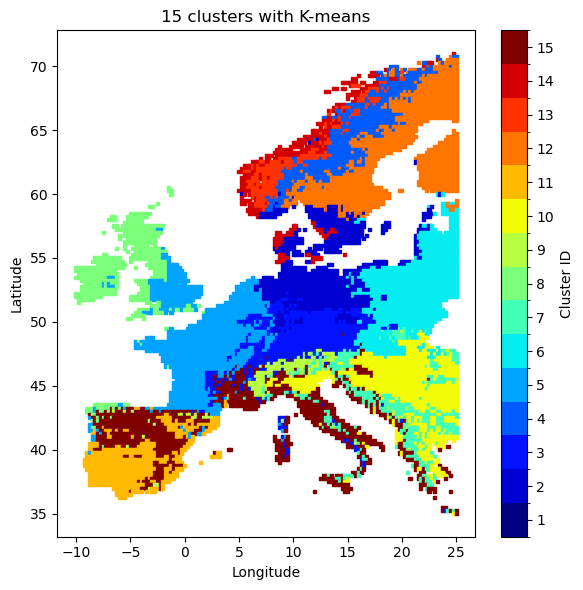

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_13149/886983864.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', len(unique_labels))  # Use a colormap with sufficient discrete colors


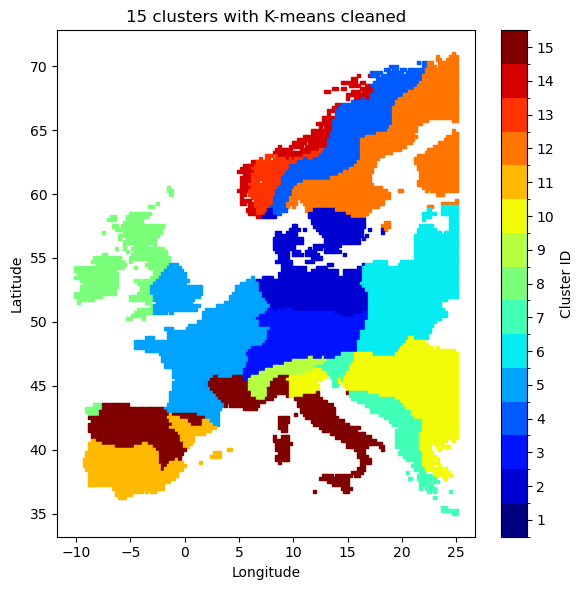

In [40]:
'''def plot_clusters(data, cluster_label, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(
        data['Longitude'],
        data['Latitude'],
        c=data[cluster_label],
        cmap='viridis',
        s=10
    )
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()
'''
final_cluster = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v2.csv', index_col=0)
final_cluster['cluster_n'] = final_cluster['cluster_n'].astype(int) + 1
df_filtered_small['cluster_kmeans_3'] = df_filtered_small['cluster_kmeans_3'].astype(int) + 1

import matplotlib.colors as mcolors

def plot_clusters(data, cluster_label, title, ax=None):
    if ax is None:
        ax = plt.gca()  # Use the current axis if none is provided
    scatter = ax.scatter(
        data['Longitude'],
        data['Latitude'],
        c=data[cluster_label],
        cmap='turbo',
        s=10
    )
    plt.colorbar(scatter, ax=ax, label='Cluster')  # Add colorbar to each subplot
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    # Function to plot clusters with a discrete colorbar
def plot_clusters_discrete(data, cluster_label, title, ax=None):
    if ax is None:
        ax = plt.gca()  # Use the current axis if none is provided

    # Get the unique cluster labels
    unique_labels = sorted(data[cluster_label].unique())

    # Create a ListedColormap for discrete colors
    cmap = plt.cm.get_cmap('jet', len(unique_labels))  # Use a colormap with sufficient discrete colors
    norm = mcolors.BoundaryNorm(boundaries=range(len(unique_labels) + 1), ncolors=len(unique_labels))

    # Define boundaries and positions for ticks
    boundaries = range(len(unique_labels) + 1)
    ticks = [(boundaries[i] + boundaries[i + 1]) / 2 for i in range(len(boundaries) - 1)]  # Midpoints of each color

    # Create the scatter plot
    scatter = ax.scatter(
        data['Longitude'],
        data['Latitude'],
        c=data[cluster_label],
        cmap=cmap,
        norm=norm,
        s=5,
        marker='s'
    )

    # Add a discrete colorbar
    cbar = plt.colorbar(scatter, ax=ax, ticks=ticks, boundaries = boundaries, label='Cluster ID')  #
    cbar.ax.set_yticklabels(unique_labels)  # Ensure proper labels on the colorbar

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)


# Visualisation des clusters K-means

#plot_clusters(df_filtered_small, 'cluster_kmeans_3', 'Clusters avec K-means (3 composantes standardisées: latitude, longitude, wind speed)')
#plot_clusters(df_filtered_small, 'cluster_kmeans_1', 'Clusters avec K-means (1 composante standardisée: wind speed (standardisée))')

# Visualisation des clusters DBSCAN
#plot_clusters(df_filtered_small, 'cluster_dbscan', 'Clusters avec DBSCAN (3 composantes: latitude, longitude, wind speed (standardizée))')

# Set up the figure and subplots (1 row, 3 columns)
#fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.figure(figsize=(6, 6))
ax = plt.gca()

# Plot each cluster result in a different subplot
#plot_clusters(df_filtered_small, 'cluster_kmeans_3', f'{k} clusters with K-means', ax=ax)
plot_clusters_discrete(df_filtered_small, 'cluster_kmeans_3', f'{k} clusters with K-means', ax=ax)
#plot_clusters(df_filtered_small, 'cluster_kmeans_1', 'Clusters avec K-means\n(1 composante standardisée: wind speed (standardisée))', ax=axes[1])
#plot_clusters(df_filtered_small, 'cluster_dbscan', 'Clusters avec DBSCAN\n(3 composantes: latitude, longitude, wind speed (standardisée))', ax=axes[2])

# Adjust layout to avoid overlap and improve spacing
plt.tight_layout()
plt.savefig(f'pre_processing/cluster/figures/cluster_map_{k}.png', dpi=300)
plt.show()

plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_clusters_discrete(final_cluster, 'cluster_n', f'{k} clusters with K-means cleaned', ax=ax)
plt.tight_layout()
plt.savefig(f'pre_processing/cluster/figures/cluster_map_{k}_cleaned.png', dpi=300)
plt.show()

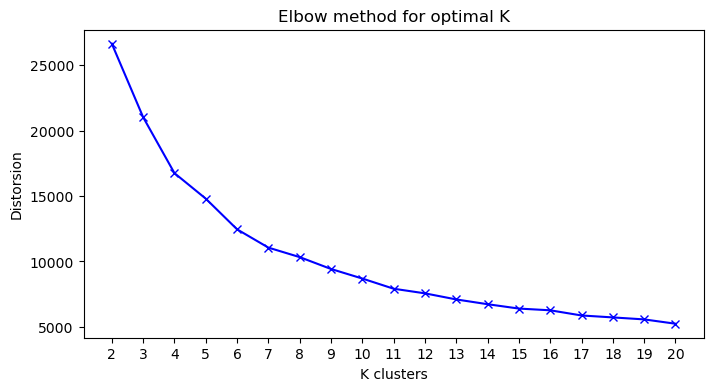

In [57]:
# Méthode du coude pour trouver le nombre optimal de clusters
distortions = []
K = range(2, 21)
for k in K:
    kmeans_3_dist = KMeans(n_clusters=k, random_state=42)
    kmeans_3_dist.fit(X_scaled_small)
    distortions.append(kmeans_3_dist.inertia_)
    labels = pd.Series(kmeans_3_dist.labels_).reset_index(drop=True)
    coordinates_temp = coordinates_small.reset_index(drop=True)
    temp = pd.concat([coordinates_temp,labels], axis=1)
    temp.columns = ['Latitude', 'Longitude', 'cluster']
    temp.to_csv(f'pre_processing/cluster/number_of_clusters/cluster_{k}.csv', index=False)

plt.figure(figsize=(8, 4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('K clusters')
plt.xticks(K)
plt.ylabel('Distorsion')
plt.title('Elbow method for optimal K')
plt.savefig('pre_processing/cluster/figures/elbow_method.png', dpi=300)
plt.show()

Score de silhouette pour K-means (3 composantes): 0.29
Score de silhouette pour K-means (1 composante): 0.29
Score de silhouette pour DBSCAN: 0.74


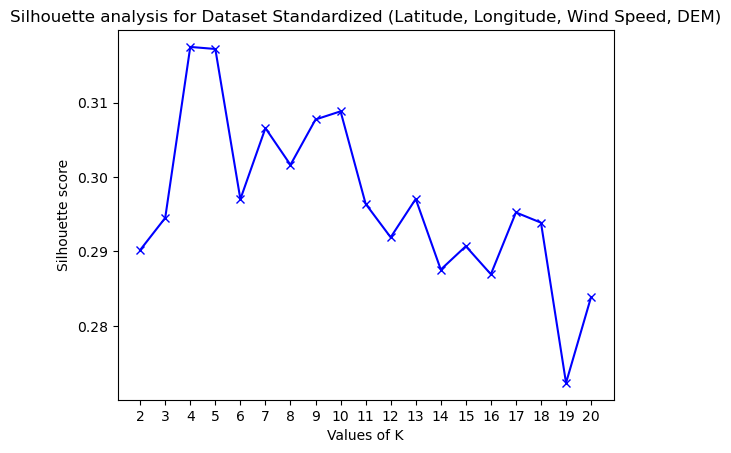

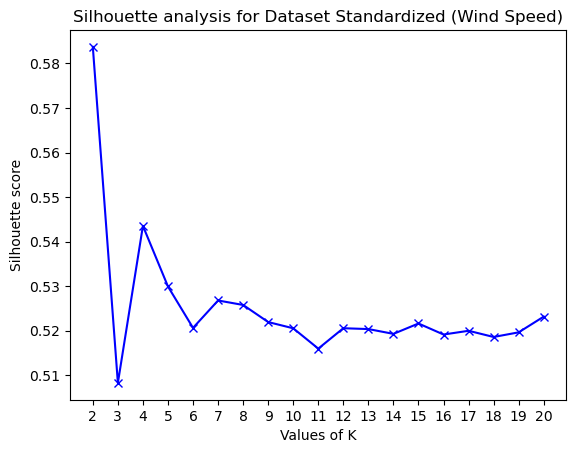

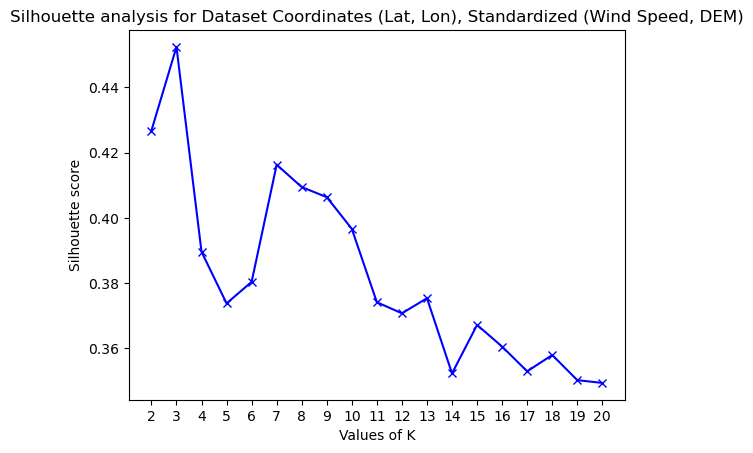

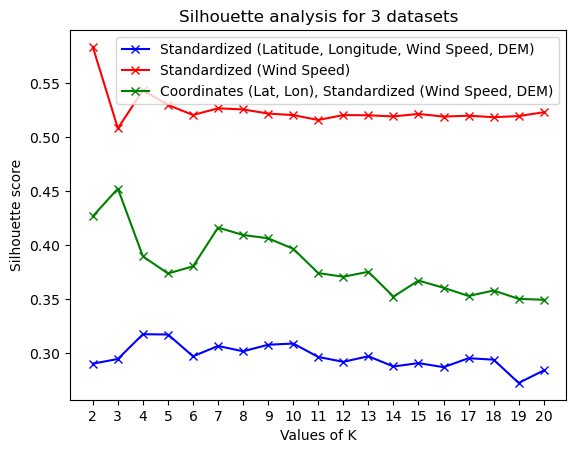

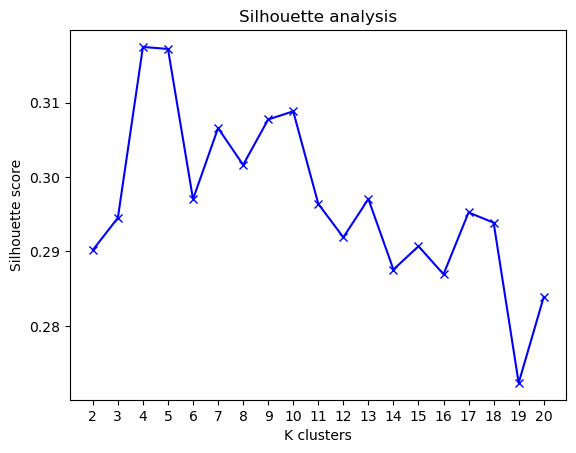

In [56]:
# see the silhouette score

from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour K-means (3 composantes)
score_kmeans_3 = silhouette_score(X_scaled_small, kmeans_3.fit_predict(X_scaled_small))#kmeans_3.labels_)
# Calcul du score de silhouette pour K-means (1 composante)
score_kmeans_1 = silhouette_score(X_scaled_small, kmeans_1.fit_predict(X_scaled_small))#labels_)
# Calcul du score de silhouette pour DBSCAN
score_dbscan = silhouette_score(X_scaled_dbscan_small, dbscan.fit_predict(X_scaled_dbscan_small))#.labels_)

print(f'Score de silhouette pour K-means (3 composantes): {score_kmeans_3:.2f}')
print(f'Score de silhouette pour K-means (1 composante): {score_kmeans_1:.2f}')
print(f'Score de silhouette pour DBSCAN: {score_dbscan:.2f}')

silhouette_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # range of clusters
datasets = [X_scaled_small, X_scaled_dbscan_small, X_scaled_wind_small]

# Define range of clusters and datasets
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18 , 19, 20] # 2, 3, 4, 5, 6, 7, 8, 9, 
datasets = [X_scaled_small, X_scaled_wind_small, dbscan_df_small]
name_dataset = ['Standardized (Latitude, Longitude, Wind Speed, DEM)', 'Standardized (Wind Speed)', 'Coordinates (Lat, Lon), Standardized (Wind Speed, DEM)']


# Loop through datasets
for idx, dataset in enumerate(datasets):
    silhouette_avg = []  # Reset silhouette_avg for each dataset
    name = name_dataset[idx]
    for cluster in range_n_clusters:
        # Fit KMeans
        kmeans_test = KMeans(n_clusters=cluster, random_state=42)
        kmeans_test.fit(dataset)
        cluster_labels = kmeans_test.labels_
        # Calculate silhouette score
        silhouette_avg.append(silhouette_score(dataset, cluster_labels))
    
    # Plot silhouette analysis
    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('Values of K')
    plt.xticks(range_n_clusters)
    plt.ylabel('Silhouette score')
    plt.title(f'Silhouette analysis for Dataset {name}')
    plt.show()
    locals()['silhouette_avg_' + str(idx)] = silhouette_avg

# Plot silhouette analysis for each dataset

plt.plot(range_n_clusters, silhouette_avg_0, 'bx-',
         range_n_clusters, silhouette_avg_1, 'rx-',
         range_n_clusters, silhouette_avg_2, 'gx-')
plt.xlabel('Values of K')
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette score')
plt.title(f'Silhouette analysis for 3 datasets')
plt.legend(['Standardized (Latitude, Longitude, Wind Speed, DEM)', 'Standardized (Wind Speed)', 'Coordinates (Lat, Lon), Standardized (Wind Speed, DEM)'])
plt.show()

# Plot silhouette analysis for each dataset

plt.plot(range_n_clusters, silhouette_avg_0, 'bx-')
plt.xlabel('K clusters')
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette score')
plt.title(f'Silhouette analysis')
#plt.legend(['Standardized (Latitude, Longitude, Wind Speed, DEM)'])
plt.savefig('pre_processing/cluster/figures/silhouette_analysis.png', dpi=300)
plt.show()

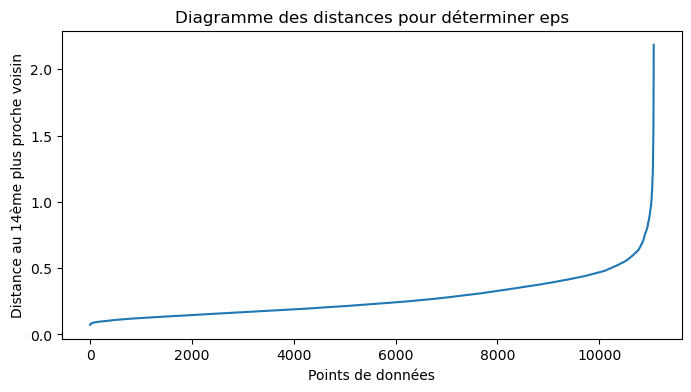

In [38]:
from sklearn.neighbors import NearestNeighbors

# Calcul des distances aux k plus proches voisins
k = 14  # k est généralement égal à min_samples
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Tri des distances pour trouver un point d'inflexion
distances = np.sort(distances[:, k-1], axis=0)

# Visualisation du diagramme des distances
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel('Points de données')
plt.ylabel(f'Distance au {k}ème plus proche voisin')
plt.title('Diagramme des distances pour déterminer eps')
plt.show()

In [31]:
# apply the pca

pca = PCA(n_components=3)
pca.fit(df_filtered)
pca_data = pca.transform(df_filtered)

[8.5346783e-01 1.4653217e-01 6.6739224e-30]


KeyError: 'Wind Speed'

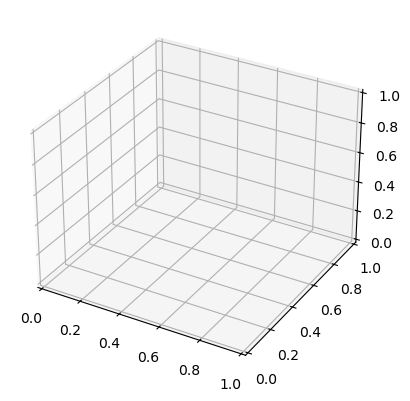

In [32]:
# see how much variance is explained by the first 3 components

print(pca.explained_variance_ratio_)

# plot the first two components

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], c=df_filtered['Wind Speed'])
plt.show()

In [ ]:
# try with DBSCAN

for i in range(1,1000): 
    e = i/100 #keeping eps = 1.63, 0.83, 0.65, 0.87
    (print(e))
    #e=0.65

    db = DBSCAN(eps=e, min_samples=15).fit(dbscan_df)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

0.01
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.02
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.03
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.04
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.05
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.06
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.07
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.08
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.09
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.1
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.11
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.12
Estimated number of clusters: 0
Estimated number of noise points: 17366
0.13
Estimated number of clusters: 0
Estimated number of noise points: 17366


KeyboardInterrupt: 

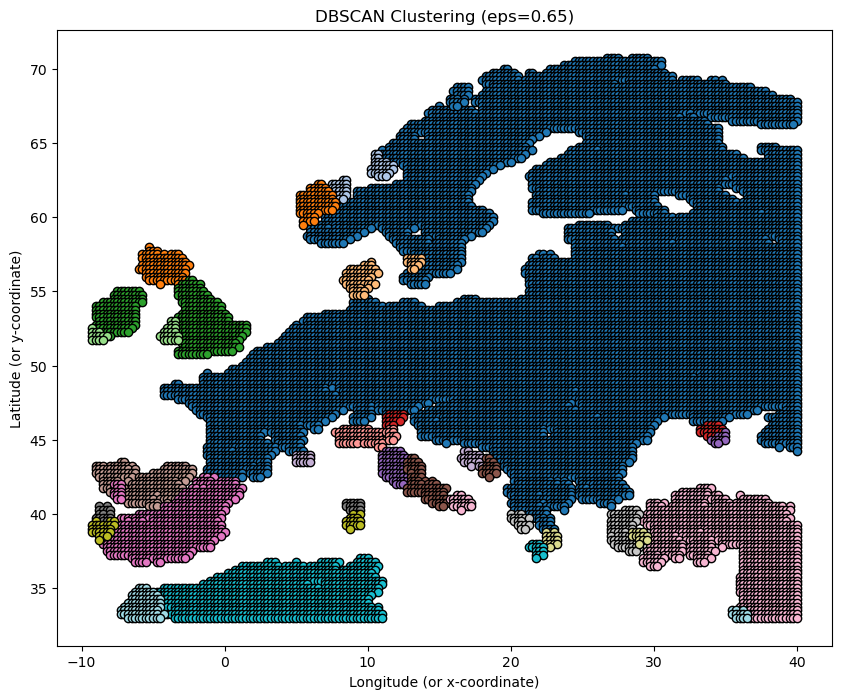

In [85]:
import matplotlib.pyplot as plt

# Extract coordinates and cluster labels
x = df_filtered['Longitude']  # Replace 'x' with your longitude (or projected x)
y = df_filtered['Latitude']  # Replace 'y' with your latitude (or projected y)

# Scatter plot
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters_))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    plt.plot(
        x[class_member_mask],
        y[class_member_mask],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
    )

plt.title("DBSCAN Clustering (eps={})".format(e))
plt.xlabel("Longitude (or x-coordinate)")
plt.ylabel("Latitude (or y-coordinate)")
plt.show()